In [1]:
!pip install pytorch-lightning
!pip install torchvision
!pip install matplotlib
!pip install datasets
!pip install wandb
!pip install --upgrade ipywidgets

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchmetrics
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch
import numpy as np
from datasets import load_dataset
from torchvision.transforms import v2
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# from torchvision.models import efficientnet_b6, EfficientNet_B6_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights 
from pytorch_lightning.loggers import WandbLogger

In [3]:
from pytorch_lightning.loggers import WandbLogger
from kaggle_secrets import UserSecretsClient
import wandb
import os

secret_label = "wand_token"
secret_value = UserSecretsClient().get_secret(secret_label)

os.environ["WANDB_API_KEY"] = secret_value

wandb_logger = WandbLogger(project="animation_types")

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: s26048 (s26048-polish-japanese-academy-of-information-technology-). Use `wandb login --relogin` to force relogin


True

In [4]:
class AnimationTypesDatamodule(pl.LightningDataModule):
  def __init__(self, batch_size = 32):
    super().__init__()
    self.batch_size = batch_size
  def setup(self, stage = None):
    transform = v2.Compose([
                        # v2.To
                        v2.ToImage(),
                        v2.Resize(256),
                        v2.CenterCrop(224),
                        v2.RandomHorizontalFlip(p=0.5),
                        v2.RandomRotation(30),
                        v2.RandomVerticalFlip(p=0.5),
                        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        v2.ToDtype(torch.float32, scale=True), # v2.ToTensor()
                        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ])


    transform_vt = v2.Compose([
                        v2.ToImage(),
                        v2.Resize(256),
                        v2.CenterCrop(224),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ])


    def transforms(examples):
        examples["pixel_values"] = [transform(img.convert("RGB")) for img in examples["image"]]
        del examples["image"]
        return examples

    def transforms_vt(examples):
        examples["pixel_values"] = [transform_vt(img.convert("RGB")) for img in examples["image"]]
        del examples["image"]
        return examples

    dataset = load_dataset("krowiemlekommm/ANIMATION_TYPES_3.0")
    
    self.train_dataset = dataset["train"].with_transform(transforms)
    self.test_dataset = dataset["test"].with_transform(transforms_vt)
    self.val_dataset = dataset["validation"].with_transform(transforms_vt)

  def train_dataloader(self):
    return  DataLoader(self.train_dataset, num_workers = 4, batch_size = self.batch_size, shuffle = True)
  def test_dataloader(self):
    return  DataLoader(self.test_dataset, num_workers = 4, batch_size = self.batch_size, shuffle = False)
  def val_dataloader(self):
    return  DataLoader(self.val_dataset, num_workers = 4, batch_size = self.batch_size, shuffle = False)

In [5]:
dm = AnimationTypesDatamodule()

In [6]:
dm.setup()

README.md:   0%|          | 0.00/683 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/58.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/46.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4966 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1027 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1100 [00:00<?, ? examples/s]

In [7]:
dm.train_dataset[0]

{'label': 0,
 'pixel_values': Image([[[-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
         [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
         [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
         ...,
         [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
         [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
         [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494]],
 
        [[-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
         [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
         [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
         ...,
         [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
         [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
         [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657]],
 
        [[-1.7347, -1.7347, -1.7347,  ..., -1.7347, -1.7347, -1.7347],
         [-1.7

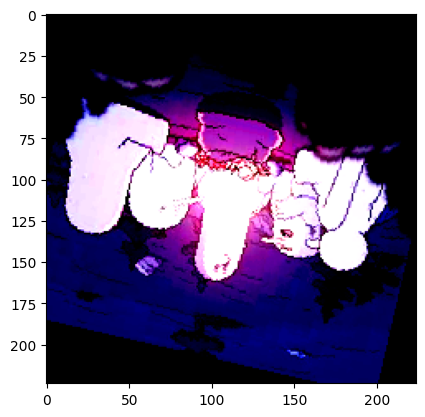

In [8]:
img = dm.train_dataset[0]["pixel_values"]
img = img.permute(1, 2, 0)
plt.imshow(img)

In [9]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import torch.nn as nn

class MovieFrame(pl.LightningModule):
    def __init__(self, layer1_size, dropout_rate, lr, num_classes=4):
        super().__init__()
        self.model = models.efficientnet_b0(weights = EfficientNet_B0_Weights.IMAGENET1K_V1) 
        self.backbone = self.model.features
        self.pooling = self.model.avgpool
        self.dropout = nn.Dropout(p=dropout_rate, inplace=True)
        self.fc1 = nn.Linear(1280 , layer1_size)
        self.fc2 = nn.Linear(layer1_size, num_classes)
        self.lr = lr
        self.loss_function = nn.CrossEntropyLoss()

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

        self.train_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, task="multiclass", average='macro')
        self.val_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, task="multiclass", average='macro')
        self.test_f1 = torchmetrics.F1Score(num_classes=num_classes, task="multiclass", average='macro')
        

        self.train_macro_recall = torchmetrics.Recall(num_classes=num_classes, task="multiclass", average='macro')
        self.val_macro_recall = torchmetrics.Recall(num_classes=num_classes, task="multiclass", average='macro')

        self.train_macro_precision = torchmetrics.Precision(num_classes=num_classes, task="multiclass", average='macro')
        self.val_macro_precision = torchmetrics.Precision(num_classes=num_classes, task="multiclass", average='macro')

        
        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
      self.backbone.eval()
      with torch.no_grad():
          x = self.backbone(x)
          x = self.pooling(x).flatten(1)
      x = self.dropout(x)
      x = F.relu(x)
      x = self.fc1(x)
      x = self.dropout(x)
      x = F.relu(x)
      x = self.fc2(x)

      return x
    

    def configure_optimizers(self):
      optimizer =  optim.Adam(self.parameters(), lr=self.lr)
      return optimizer

    def training_step(self, train_batch, batch_idx):
      inputs, labels = train_batch["pixel_values"], train_batch["label"]


      outputs = self.forward(inputs.float())
      loss = self.loss_function(outputs, labels)


      self.log('train_loss', loss, on_step = True, on_epoch = True)

      outputs = F.softmax(outputs, dim =1)

      self.train_acc(outputs, labels)
      self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)

      self.train_macro_f1(outputs, labels)
      self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)

      self.train_macro_recall(outputs, labels)
      self.log('train_macro_recall', self.train_macro_recall, on_epoch=True, on_step= False)

      self.train_macro_precision(outputs, labels)
      self.log('train_macro_precision', self.train_macro_precision, on_epoch=True, on_step= False)



      return loss

    def validation_step(self, val_batch, batch_idx):
      inputs, labels = val_batch["pixel_values"], val_batch["label"]

      outputs = self.forward(inputs.float())
      loss = self.loss_function(outputs, labels)

      self.log('val_loss', loss,  on_step= True, on_epoch = True, sync_dist=True)

      outputs = F.softmax(outputs, dim =1)

      self.val_acc(outputs, labels)
      self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)

      self.val_macro_f1(outputs, labels)
      self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

      self.val_macro_recall(outputs, labels)
      self.log('val_macro_recall', self.val_macro_recall, on_epoch=True, on_step= False)

      self.val_macro_precision(outputs, labels)
      self.log('val_macro_precision', self.val_macro_precision, on_epoch=True, on_step= False)

      return loss


    def test_step(self, batch, batch_idx):
        # this is the test loop
        inputs, labels = batch["pixel_values"], batch["label"]
        outputs = self.forward(inputs.float())
        
        loss = self.loss_function(outputs, labels)
        self.log("test_loss", loss)

        self.test_acc(outputs, labels)
        self.log('test_acc', self.test_acc)
        
        self.test_f1(outputs, labels)
        self.log('test_f1', self.test_f1)


In [10]:
sweep_configuration = {
    'method': 'random',
    'name': 'effnet_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_macro_f1'},
    'parameters': {
        'batch_size': {'values': [32, 64, 128]},
        'n_epochs': {'values': [10, 20, 30]},
        'learning_rate': {'max': 0.01, 'min': 0.00001},
        'layer1_size': {'values': [256, 512, 1024]},
        'dropout_rate': {'values': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]},
    }
}

In [11]:
def sweep_train(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config
        wandb_logger = WandbLogger(project="effnet_sweep", log_model=True, name=f"sweep_run_{wandb.run.id}")
        name_str = f"EfficienNet-B0_{config.layer1_size}_{str(config.learning_rate)[:8]}"
        run.name = name_str
        dm = AnimationTypesDatamodule(batch_size=config.batch_size)
        dm.setup()

        model = MovieFrame(
            num_classes=4,
            layer1_size=config.layer1_size,
            dropout_rate=config.dropout_rate,
            lr=config.learning_rate,
        )

        trainer = pl.Trainer(accelerator="gpu",
                             logger=wandb_logger,
                             max_epochs=config.n_epochs,
                            callbacks=[EarlyStopping(monitor="val_macro_f1", mode="max", patience=3)])
        trainer.fit(model, dm)
        trainer.test(model,dm)
        wandb.finish()


In [12]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project='effnet_sweep')

Create sweep with ID: dmftq1qt
Sweep URL: https://wandb.ai/s26048-polish-japanese-academy-of-information-technology-/effnet_sweep/sweeps/dmftq1qt


In [13]:
wandb.agent(sweep_id, function=sweep_train, count=30)

wandb: Agent Starting Run: xu6pun4t with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.00162947803269243
wandb: 	n_epochs: 10


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 90.8MB/s]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7618181705474854     │
│          test_f1          │    0.7621335387229919     │
│         test_loss         │    0.5762776136398315     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▅▇█▇█
train_loss_epoch,█▃▂▁▁▁
train_loss_step,▄▅█▅▄▅▄▂▄▃▆▅▆▃▇▄▁▄
train_macro_f1,▁▅▇█▇█
train_macro_precision,▁▅▇█▇█
train_macro_recall,▁▅▇█▇█
trainer/global_step,▂▁▁▁▁▁▄▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂█▂▂▂▂▂█▂▂▂▃▃▃▃▃


wandb: Agent Starting Run: zeort4k3 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.00706964964963106
wandb: 	n_epochs: 20


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7454545497894287     │
│          test_f1          │    0.7416393756866455     │
│         test_loss         │    0.6272532939910889     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇███
train_loss_epoch,█▂▁▁▁▁
train_loss_step,▃▅▃▂▁▂█▂▆
train_macro_f1,▁▆▇███
train_macro_precision,▁▆▇███
train_macro_recall,▁▆▇███
trainer/global_step,▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▄▁▂▂▂▄▅▂▂▂▆▂▂▂▂▂▂▂▂▇▂▂▂▂█


wandb: Agent Starting Run: b0ln6uz7 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.004832365938258879
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7490909099578857     │
│          test_f1          │    0.7526398301124573     │
│         test_loss         │    0.5964179039001465     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▇▇▇████
train_loss_epoch,█▂▂▂▂▁▁▁
train_loss_step,▅▆▅▄█▁
train_macro_f1,▁▇▇▇████
train_macro_precision,▁▇▇▇████
train_macro_recall,▁▇▇▇████
trainer/global_step,▁▁▁▁▁▁▂▁▁▁▃▁▁▁▁▂▂▄▂▂▂▂▂▂▄▂▂▅▂▂▇▂▂▂▇▂▂▃▃█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pvzzb4jm with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.6
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.0022262410737588735
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7400000095367432     │
│          test_f1          │    0.7367904186248779     │
│         test_loss         │    0.6269339323043823     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇▆▇██
train_loss_epoch,█▄▂▂▃▁▁
train_loss_step,▅▇▄▆▂▃▅▂▄▂▇▄▄▅▅█▃▂▁▇▇
train_macro_f1,▁▆▇▆▇██
train_macro_precision,▁▆▇▆▇▇█
train_macro_recall,▁▆▇▆▇██
trainer/global_step,▂▁▁▁▁▂▂▁▁▁▁▁▃▃▁▂▂▂▂▆▂▂▂▂▂▇▂▂▂▂▂▂▇█▂▂▂▂▂▂


wandb: Agent Starting Run: ou88hh6s with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.008402320229253182
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7436363697052002     │
│          test_f1          │    0.7417575716972351     │
│         test_loss         │    0.6307381391525269     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▂▂▂▃▃▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇▇▇▇██▇█
train_loss_epoch,█▂▂▂▂▁▁▁▁▁
train_loss_step,▇█▅▁▅▃▁
train_macro_f1,▁▆▇▇▇▇██▇█
train_macro_precision,▁▆▇▇▇▇██▇█
train_macro_recall,▁▆▇▇▇▇██▇█
trainer/global_step,▁▁▁▁▁▂▁▁▁▁▁▂▂▃▁▃▃▂▂▂▂▄▂▂▂▅▂▂▆▂▂▂▂▇▂▂▂▂▂█


wandb: Agent Starting Run: ozkuehjg with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.0006986606261683355
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7554545402526855     │
│          test_f1          │    0.7546714544296265     │
│         test_loss         │    0.6046761870384216     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▅▆▆▇▇████
train_loss_epoch,█▄▃▃▂▂▂▁▁▁
train_loss_step,▆▃▆▂▂▄▅▅▄█▄▅▂▆▂▄▂▄▄▃▃▁▂▃▄▅▂▃▄▁▃
train_macro_f1,▁▅▆▇▇▇████
train_macro_precision,▁▅▆▇▇▇████
train_macro_recall,▁▅▆▆▇▇████
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▅▂▂▂▂▆▂▂▂▇▂▂█▂▂▃


wandb: Agent Starting Run: y7mvfzsp with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.005999915349797356
wandb: 	n_epochs: 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7527272701263428     │
│          test_f1          │    0.7526825666427612     │
│         test_loss         │    0.5957909226417542     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▇▇▇▇▇█▇█
train_loss_epoch,█▂▂▁▁▁▁▁▁
train_loss_step,▆▁▅█▆▆▅
train_macro_f1,▁▇▇█▇▇█▇█
train_macro_precision,▁▇▇█▇▇█▇█
train_macro_recall,▁▇▇▇▇▇█▇█
trainer/global_step,▁▁▁▁▁▁▁▂▁▁▁▃▃▃▁▁▁▁▁▄▂▂▂▂▂▂▂▂▅▂▂▂▂▂▇▂▂▂▂█


wandb: Agent Starting Run: pjhbmo7p with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.0025497586676845553
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7654545307159424     │
│          test_f1          │    0.7641470432281494     │
│         test_loss         │    0.5984426140785217     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇▆█
train_loss_epoch,█▃▂▃▁
train_loss_step,█▃▃▂▂▂▃▃▄▁▆▅▄▂▁
train_macro_f1,▁▆▇▆█
train_macro_precision,▁▆▇▆█
train_macro_recall,▁▆▇▆█
trainer/global_step,▁▂▁▁▁▃▃▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▆▂▂▂▂▂▂▂▇▇▂▂▂▂█


wandb: Agent Starting Run: 9oy9ak6q with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.0008832436364522041
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7627272605895996     │
│          test_f1          │    0.7658915519714355     │
│         test_loss         │    0.6345940232276917     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▄▄▄▅▅▅▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▇███
train_loss_epoch,█▃▂▂▁
train_loss_step,██▁
train_macro_f1,▁▇▇██
train_macro_precision,▁▇▇██
train_macro_recall,▁▇███
trainer/global_step,▁▁▁▁▁▁▂▃▁▁▁▁▂▂▂▅▂▂▂▂▂▂▅▅▆▂▂▂▂▂▂▇▇▂▂▂▂▃▃█


wandb: Agent Starting Run: 4awvjkxo with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4
wandb: 	layer1_size: 512
wandb: 	learning_rate: 0.009102342752390356
wandb: 	n_epochs: 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7654545307159424     │
│          test_f1          │    0.7643993496894836     │
│         test_loss         │    0.6335635185241699     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁████▇
train_loss_epoch,█▁▁▁▂▁
train_loss_step,▆▅▃▄▁▅▆▄█
train_macro_f1,▁████▇
train_macro_precision,▁████▇
train_macro_recall,▁████▇
trainer/global_step,▁▁▁▁▁▁▂▁▁▁▁▂▂▂▂▄▅▂▂▂▂▂▂▆▆▂▂▂▂▂▂▂▇▇▇▂▂▂▂█


wandb: Agent Starting Run: 3oyv62ar with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	layer1_size: 512
wandb: 	learning_rate: 0.007077260167064558
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7281818389892578     │
│          test_f1          │     0.729405403137207     │
│         test_loss         │    0.6308290958404541     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▃▃▃▃▅▅▅▆▆▆▆█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▇▇█
train_loss_epoch,█▂▂▁
train_loss_step,█▁▅▇▂▅
train_macro_f1,▁█▇█
train_macro_precision,▁█▇█
train_macro_recall,▁▇▇█
trainer/global_step,▁▁▁▁▁▁▁▃▃▄▁▁▂▂▂▂▂▄▄▅▂▂▂▂▂▂▆▆▇█▂▂▂▂▂▂▂▂▂█


wandb: Agent Starting Run: tkd71798 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.0018425048705936016
wandb: 	n_epochs: 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7663636207580566     │
│          test_f1          │    0.7639403343200684     │
│         test_loss         │    0.5998179316520691     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▄▅▆▆▆▆▇▇█
train_loss_epoch,█▅▄▄▃▃▂▂▁▁
train_loss_step,▇▅▄█▅▄▃▄▄▂▃▃▁▃▂
train_macro_f1,▁▄▅▆▆▆▆▇▇█
train_macro_precision,▁▄▅▆▆▆▆▇▇█
train_macro_recall,▁▄▅▆▆▆▆▇▇█
trainer/global_step,▁▁▁▂▂▁▃▁▁▁▁▄▁▁▂▂▄▂▂▂▂▄▄▂▂▂▅▂▂▂▂▂▇▇▇▂▂▂▂█


wandb: Agent Starting Run: ixmw8cu0 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.008841339761129823
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7290909290313721     │
│          test_f1          │    0.7306820154190063     │
│         test_loss         │    0.6410027742385864     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▅▆▇▇▇█▇
train_loss_epoch,█▂▂▁▁▁▁▁▁
train_loss_step,▅▂▄▅▃▃▃█▃▄▅▁▂▄
train_macro_f1,▁▆▅▆▇▇▇█▇
train_macro_precision,▁▆▅▆▇▇▇█▇
train_macro_recall,▁▆▅▆▇▇▇█▇
trainer/global_step,▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▄▂▂▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█


wandb: Agent Starting Run: xaikey3h with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.0006648819590633228
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7509090900421143     │
│          test_f1          │    0.7551337480545044     │
│         test_loss         │    0.5867570638656616     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▆▆████
train_loss_epoch,█▃▃▂▁▁▂▁
train_loss_step,▇▂▃▁█▃
train_macro_f1,▁▆▆▆████
train_macro_precision,▁▅▆▆████
train_macro_recall,▁▆▆▆████
trainer/global_step,▁▁▁▁▂▁▁▁▃▁▁▂▄▂▂▂▂▂▄▂▂▂▅▅▂▂▂▂▂▂▂▂▂▂▂█▂▃▃█


wandb: Agent Starting Run: ky3th0j4 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.0006152920507968662
wandb: 	n_epochs: 30


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7472727298736572     │
│          test_f1          │     0.747472882270813     │
│         test_loss         │    0.6293506622314453     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▇▇███
train_loss_epoch,█▃▂▂▁▁
train_loss_step,▇▆█▃▂▃▂▃▁
train_macro_f1,▁▇▇▇██
train_macro_precision,▁▇▇▇██
train_macro_recall,▁▇▇███
trainer/global_step,▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▂▅▂▂▂▂▂▂▂▆▂▂▂▂▇▇▂▂▂▂█


wandb: Agent Starting Run: ntfp5llx with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.006334959184625096
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7599999904632568     │
│          test_f1          │    0.7615468502044678     │
│         test_loss         │    0.6020007133483887     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▆█▇▇███
train_loss_epoch,█▃▃▂▁▂▁▁▁
train_loss_step,▆█▃▅▅▁▇
train_macro_f1,▁▆▆█▇▇███
train_macro_precision,▁▆▆█▇▇███
train_macro_recall,▁▆▆█▇▇███
trainer/global_step,▁▁▁▁▁▁▁▃▃▁▂▂▂▂▂▂▂▄▂▂▅▂▂▂▂▆▂▂▂▂▂▇▇▂▂██▃▃▃


wandb: Agent Starting Run: ei239daa with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.6
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.003651730337339793
wandb: 	n_epochs: 30


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7372727394104004     │
│          test_f1          │    0.7374060153961182     │
│         test_loss         │    0.6469216346740723     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▅▆▇███▇
train_loss_epoch,█▃▃▂▁▂▁▂
train_loss_step,▆▇▄█▃▇▄▄▄▆▇▆▅▃▁▄▆▃▅▃▄▅▄▃
train_macro_f1,▁▅▆▇▇██▇
train_macro_precision,▁▅▆▇▇██▇
train_macro_recall,▁▅▆▇███▇
trainer/global_step,▂▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▂▂▅▂▂▂▂▂▂▂▂▂▆▇▂▂▂▂▂▂▂▂▂█


wandb: Agent Starting Run: lmc53p75 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.00037890643467608655
wandb: 	n_epochs: 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7645454406738281     │
│          test_f1          │    0.7649452090263367     │
│         test_loss         │    0.6223329901695251     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇▇███
train_loss_epoch,█▃▂▂▂▁▁
train_loss_step,█▂▅▇▆▁▄▅▁▃
train_macro_f1,▁▆▇████
train_macro_precision,▁▆▇████
train_macro_recall,▁▆▇▇███
trainer/global_step,▁▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▂▄▂▂▂▂▂▂▂▂▆▆▂▂▂▂▂▇▇▂▂█


wandb: Agent Starting Run: upzi47j0 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.005038761807552691
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7681818008422852     │
│          test_f1          │    0.7671151757240295     │
│         test_loss         │    0.5644567012786865     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▇▇██▇█
train_loss_epoch,█▂▂▁▂▂▁
train_loss_step,█▂▅▂▁
train_macro_f1,▁▇▇██▇█
train_macro_precision,▁▇▇██▇█
train_macro_recall,▁▇▇██▇█
trainer/global_step,▁▁▁▁▂▂▁▁▁▁▃▄▁▁▂▂▂▄▂▂▂▂▂▂▂▆▆▆▂▂▂▂▂▂▇▂▂▂▃█


wandb: Agent Starting Run: 7za837ki with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.003596034693134302
wandb: 	n_epochs: 30


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.75            │
│          test_f1          │     0.748633086681366     │
│         test_loss         │    0.6364052295684814     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▅▅▆▆▇▇▇▇▇█
train_loss_epoch,█▄▄▃▃▃▂▂▂▂▁
train_loss_step,▇▃▆▁▅▂█▅
train_macro_f1,▁▅▅▆▆▇▇▇▇▇█
train_macro_precision,▁▅▅▆▆▇▇▇▇▇█
train_macro_recall,▁▅▅▆▆▇▇▇▇▇█
trainer/global_step,▁▁▁▁▁▂▁▁▂▁▁▄▂▂▂▂▂▂▂▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃█▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tl881gwb with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.000865920056978811
wandb: 	n_epochs: 30


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7527272701263428     │
│          test_f1          │    0.7542524337768555     │
│         test_loss         │    0.6016164422035217     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▅▆▇▆█
train_loss_epoch,█▄▃▃▂▁
train_loss_step,▄▃▂▃▂▂▁▃▄▂▃▂▃▃▁▂▃█
train_macro_f1,▁▅▆▇▆█
train_macro_precision,▁▅▆▇▆█
train_macro_recall,▁▅▆▇▆█
trainer/global_step,▁▁▁▁▂▁▁▁▁▁▂▂▂▂▂▅▂▂▂▂▂▂▂▆▆▂▂▂▂▂▂▂▇▂▂▂▂▂▂█


wandb: Agent Starting Run: azywf4b4 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.004546516244078008
wandb: 	n_epochs: 30


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7672727108001709     │
│          test_f1          │     0.765866756439209     │
│         test_loss         │    0.5823248028755188     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▅▆▇█▇██
train_loss_epoch,█▄▃▃▂▂▁▁▁
train_loss_step,█▄▄▄▄▅▂▁▅▃▃▃▃▅
train_macro_f1,▁▆▅▆▇█▇██
train_macro_precision,▁▆▅▆▇█▇██
train_macro_recall,▁▆▅▆▇█▇██
trainer/global_step,▁▁▁▁▁▂▃▁▁▁▁▁▃▁▂▂▂▂▂▂▂▂▆▂▂▇▇▂▂▂▂██▃▃▃▃▃▃▃


wandb: Agent Starting Run: svxxlqet with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4
wandb: 	layer1_size: 512
wandb: 	learning_rate: 0.00869080765684473
wandb: 	n_epochs: 30


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7572727203369141     │
│          test_f1          │    0.7543710470199585     │
│         test_loss         │    0.6171677708625793     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▄▄▄▅▅▅▅▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇█▇
train_loss_epoch,█▂▂▁▂
train_loss_step,▆▃█▂▁▆▆
train_macro_f1,▁▆▇█▇
train_macro_precision,▁▆▇█▇
train_macro_recall,▁▆▇█▇
trainer/global_step,▁▁▁▁▁▁▁▂▂▁▁▁▂▄▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▇▇▂▂▂▂▂▂▂█


wandb: Agent Starting Run: e5nfp60j with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.007080070085672673
wandb: 	n_epochs: 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7427272796630859     │
│          test_f1          │    0.7464275360107422     │
│         test_loss         │    0.6379460096359253     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇▇▇██
train_loss_epoch,█▃▂▂▁▁▁
train_loss_step,▃▅█▅▃▄▃▃▄▅▆▃▂▂▃▃▁▂▄▃▂
train_macro_f1,▁▆▇▆▇██
train_macro_precision,▁▆▇▆▇██
train_macro_recall,▁▆▇▇▇██
trainer/global_step,▂▁▁▁▁▁▁▁▁▁▁▁▃▄▂▂▂▅▂▂▂▂▂▆▂▂▂▂▂▂▇▂▂▂▂▂▂█▃▃


wandb: Agent Starting Run: imiz00c7 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.00022838551102598225
wandb: 	n_epochs: 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7699999809265137     │
│          test_f1          │    0.7691235542297363     │
│         test_loss         │    0.6125470399856567     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▅▆▇▇▇███████████
train_loss_epoch,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▄▄▃▄▄▄▄▃▄▃▄▃▂▂▃▃▂▃▁▂▄▄▂▁
train_macro_f1,▁▅▆▇▇▇███████████
train_macro_precision,▁▅▆▇▇▇███████████
train_macro_recall,▁▅▆▇▇▇███████████
trainer/global_step,▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▇▇▂▂▂▂▂▂█▂█▂▂▃


wandb: Agent Starting Run: jsx7hj8n with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.6
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.003952232338775042
wandb: 	n_epochs: 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7336363792419434     │
│          test_f1          │    0.7334400415420532     │
│         test_loss         │    0.6494058966636658     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇▆▇█
train_loss_epoch,█▂▂▂▂▁
train_loss_step,▄▃▄▂▄▅▂▆█▃▂▁▂▂▄▃▅▄
train_macro_f1,▁▅▇▆▇█
train_macro_precision,▁▅▇▆▇█
train_macro_recall,▁▅▇▆▇█
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▁▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▆▂▂▂▂▇▂▂▂▂▂█


wandb: Agent Starting Run: b6kkojht with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.002790879948565423
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.75            │
│          test_f1          │    0.7505274415016174     │
│         test_loss         │    0.5893567204475403     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▃▃▃▅▅▅▆▆▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇▇▇█
train_loss_epoch,█▃▂▂▂▁
train_loss_step,▅▁▆█
train_macro_f1,▁▆▇▇▆█
train_macro_precision,▁▆▇▇▆█
train_macro_recall,▁▆▇▇▇█
trainer/global_step,▁▁▁▁▁▁▂▂▂▁▁▁▁▂▃▂▂▂▂▄▂▂▂▂▂▆▂▂▂▂▂▇▇▂▂▂▂▂▃█


wandb: Agent Starting Run: qu3ere7a with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	layer1_size: 256
wandb: 	learning_rate: 0.002861186792378731
wandb: 	n_epochs: 30


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7427272796630859     │
│          test_f1          │    0.7297022938728333     │
│         test_loss         │    0.6428036689758301     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▃▃▃▅▅▅▆▆▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▆███
train_loss_epoch,█▂▂▁▁▁
train_loss_step,█▁▃▄
train_macro_f1,▁▇▆███
train_macro_precision,▁▇▆███
train_macro_recall,▁▆▆███
trainer/global_step,▁▁▁▁▁▁▂▁▁▁▁▁▂▃▂▂▂▂▂▄▅▂▂▂▂▆▂▂▂▂▂▂▂▇▂▂▃▃▃█


wandb: Agent Starting Run: e8cuq341 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.008997755040854032
wandb: 	n_epochs: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.746363639831543     │
│          test_f1          │    0.7459136247634888     │
│         test_loss         │    0.6095483303070068     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▆▇█▇█
train_loss_epoch,█▂▂▁▁▁▁
train_loss_step,▄▅██▆▁▅▃▁▄
train_macro_f1,▁▆▆▇█▇█
train_macro_precision,▁▆▇▇█▇█
train_macro_recall,▁▆▆▇█▇█
trainer/global_step,▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▂▂▂▂▅▅▂▂▂▂▂▂▂▆▇▂▂▂▂▇▂▂▂█


wandb: Agent Starting Run: yon1saet with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	layer1_size: 1024
wandb: 	learning_rate: 0.0009913817060686484
wandb: 	n_epochs: 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7718181610107422     │
│          test_f1          │    0.7695397138595581     │
│         test_loss         │    0.5813581347465515     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇▇█
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▅▆▇██
train_loss_epoch,█▃▃▂▁▁
train_loss_step,█▇▄▃▃▁▃▁▁
train_macro_f1,▁▅▆▇██
train_macro_precision,▁▅▆▇██
train_macro_recall,▁▅▆▇██
trainer/global_step,▁▁▁▁▁▁▃▄▁▁▂▂▄▅▂▂▂▂▂▂▆█▂▂▂▂▂▂█▃▃▃▃▃▃▃▃▃▃▃


In [ ]:
wandb.finish()